<font color=gray>Oracle Cloud Infrastructure Data Science Demo Notebook

Copyright (c) 2021 Oracle, Inc.<br>
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font> Speech Command Recognition Task with Keras </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> OCI Data Science PM Team </font></p>

***

In this notebook, we will train a simple convolutional neural network (CNN) to recognize utterances of different words. 

![banner](https://user-images.githubusercontent.com/5395649/46774810-22395980-ccb9-11e8-8f1a-535769d657ec.png)

We'll first start by installing some libraries that are not installed in the notebook session environment. 

In [ ]:
%%bash 

pip install -r requirements.txt > .install_logs

Also upgrade the version of the OCI Python SDK that is installed in your conda environment. The new version will include support for Model Deployment. 

In [ ]:
!pip install --upgrade oci

Re-start the kernel and start from here: 

In [1]:
import keras 
import tensorflow as tf
import numpy as np
import librosa
import os 
import hashlib 
import re
import pandas as pd 
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
from tqdm import tqdm 
import pickle as pkl 
from seaborn import heatmap 

#from preprocess import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

from ads.common.model import prepare_generic_model
import ads

import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
import tensorflow as tf 
tf.logging.set_verbosity(tf.logging.ERROR)

/home/datascience/conda/speech-commands-with-deployv1_0/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


[librosa](https://librosa.github.io/librosa/) is an interesting python library for audio analysis. The paper describing the library can be found [here](http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf).

# Before we get started... 

* **If you are unfamiliar with signal processing in general, we recommend you review the notebook `1-intro-to-audio-data.ipynb`. You need to run this notebook first to download the data to your notebook session**

* You don't need the raw data to run this notebook. You will be able to load a pre-processed dataset that is stored in this repo. This dataset will work for all default parameters provided in this notebook. 

Let us define some variables that will be used throughout the notebook. 

* `data_dir` points to the `wav` folder of the dataset. On the platform, this means `/home/datascience/data/`.
* `MAX_NUM_WAVS_PER_CLASS` is the maximum number of audio clip examples per word class. Leave it as is for now.

## A few words on the dataset 

The dataset we use is the [Speech Commands Dataset](https://arxiv.org/abs/1804.03209). This dataset includes 105k utterances of 35 words. Each word has its corresponding folder containing between 1k and 4k examples. In total, **over 2K different speakers were recorded**. Each clip lasts 1 second at a sampling rate of 16 kHz. The uncompressed data take about 4Gb on disk. 

The dataset is licensed under the [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/). See the LICENSE file in the dataset folder for full details. Its original location was at
[http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz)

In [2]:
# the root directory of the dataset. If you are running this notebook on the Platform, this
# folder should be /home/datascience/data/
data_dir = '../data/'

MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

# Training, validation and testing data split. An 80-10-10% split is standard. 
training_fraction = 80.0
validation_fraction = 10.0
testing_fraction = 10.0 

# If you have not downloaded the original dataset and you want to 
# use the pre-processed, transformed dataset, set the flag "list_available_words" to False
list_available_words = False 

if list_available_words: 
    # Lets find what words are available for us to classify: 
    words_available = [ d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) ] 

    # This is the list of available utterances one can use in their classifier
    print(words_available)

For this particular model, **we will train a classifier whose purpose will be to 
classify utterances of the words "right", "eight", "cat"**

In [3]:
words_selected = ['right', 'eight', 'cat']

# Build a training, validation and testing sets

In the cells below, we build the training, validation, and training datasets that will be used to train the CNN model. 
We recommend that you load the pre-processed data. It takes a while to compute the MFCCs for these sound clips. **The pre-processed, feature-extracted data was generated for words (`right`, `eight`, `cat`) only.** If you want to use different words, you need to download the raw, original dataset.  

In [4]:
# Create the mapping between index for one-hot encoding and the class label:
class_to_int = {label:i for i, label in enumerate(words_selected)}
print(class_to_int)

# Save that lookup dictionary to disk: 
pkl.dump(class_to_int, open('./class_label_lookup.pkl','wb'))

{'right': 0, 'eight': 1, 'cat': 2}


In [5]:
# Either load the processed and feature-extracted dataset or generate your own. 
# Set this value to True unless you have downloaded the raw data locally using the shell script. 

load_preprocessed_data = True

if load_preprocessed_data: 
    df = pkl.load(open('../data/processed_data.pkl','rb'))
else: 
    tqdm.pandas()
    df = pd.DataFrame(columns=['filename','label','sample'])

    for w in words_selected: 
        files = [ f for f in os.listdir(data_dir + w) if f[-4:] == '.wav' ]
        labels = [ w for f in files]
        sample = [ which_set(f, validation_fraction, testing_fraction) for f in files ]
        tmp = pd.DataFrame({'filename':files, 'label':labels, 'sample':sample})
        df = df.append(tmp, ignore_index=True)
   
    # adding the full path, mfcc data and class label mapping 
    df['full_path'] = data_dir + df['label'] + "/" + df['filename']
    df['mfcc'] = df['full_path'].progress_apply(lambda x: data_processing(x))
    df['y_hot'] = df['label'].map(class_to_int)
    
    # save data to disk: 
    df.to_pickle('../data/processed_data.pkl')

In [6]:
df.head()

,filename,label,sample,full_path,mfcc,y_hot
0,1b88bf70_nohash_0.wav,right,training,/home/datascience/data/right/1b88bf70_nohash_0...,"[[-433.3795378509684, -434.2466677165984, -436...",0
1,b12bef84_nohash_1.wav,right,training,/home/datascience/data/right/b12bef84_nohash_1...,"[[-395.73158891078725, -374.81060233119285, -3...",0
2,05b2db80_nohash_1.wav,right,training,/home/datascience/data/right/05b2db80_nohash_1...,"[[-265.1568901743038, -266.41782567801494, -27...",0
3,b66f4f93_nohash_5.wav,right,training,/home/datascience/data/right/b66f4f93_nohash_5...,"[[-549.6284243645459, -551.6706347878757, -558...",0
4,750e3e75_nohash_0.wav,right,validation,/home/datascience/data/right/750e3e75_nohash_0...,"[[-513.6241339519378, -511.58181167935845, -51...",0


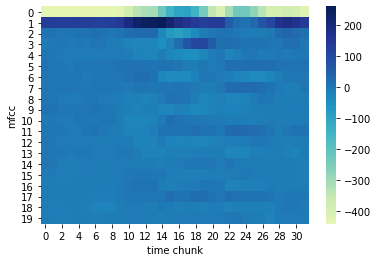

In [7]:
# Let's display the content of the column "mfcc". This column 
# contains the Mel-frequency Cepstral Coefficients (MFCC). 
# It's basically a power spectrum. 

def display_spectrogram(df, id): 
    """Given the index value of the example in the pandas dataframe 
    this function will display a 2-D heatmap of the MFCC spectrum. 
    
    Args: 
      - df (pd.DataFrame) : Dataframe of interest. 
      - id (integer) : row index of the example of interest 
    """
    ax = heatmap(df.iloc[id]['mfcc'], center=-150, cmap="YlGnBu")
    ax.set(xlabel="time chunk", ylabel="mfcc") 

# We will take a look at the first example in the t
display_spectrogram(df, 0)

In [8]:
# Sanity check: counts for each sample category. 
df['sample'].value_counts()

training      7709
testing        998
validation     889
Name: sample, dtype: int64

# Splitting into training and testing sets

Below we split the datasets by training, validation and evaluation (test) samples. 
We will use the mfcc values as the covariates/features for each clip. 

In [9]:
# Training dataset: 
X_train = df[df['sample'] == "training"]['mfcc'].values
Y_train = df[df['sample'] == "training"]['y_hot'].values

# Validation dataset: 
X_valid = df[df['sample'] == "validation"]['mfcc'].values
Y_valid = df[df['sample'] == "validation"]['y_hot'].values

# Evaluation dataset: 
X_test = df[df['sample'] == "testing"]['mfcc'].values
Y_test = df[df['sample'] == "testing"]['y_hot'].values 

In [10]:
# Reshaping the MFCCs  
Xtrain = np.asarray([ sub.reshape(20,32,1) for sub in X_train ])
Xvalid = np.asarray([ sub.reshape(20,32,1) for sub in X_valid ])
Xtest = np.asarray([ sub.reshape(20,32,1) for sub in X_test ])

# Converting the index values to categorical values using the Keras to_categorical() function 
Ytrain = to_categorical(Y_train)
Yvalid = to_categorical(Y_valid)
Ytest = to_categorical(Y_test)

In [11]:
# let's make sure we have the right dimensions for all these arrays: 
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((7709, 20, 32, 1), (7709, 3), (998, 20, 32, 1), (998, 3))

Congratulations! You are now ready to train the Convolutional Neural Network (CNN) model. 

# Training the CNN model 

I adopted a slight variation of the [Sainath & Parada (2015)](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43969.pdf) `cnn-trad-fpool3` model for the purpose of this demo. I invite the reader to read this paper for more details. 

This is a simple model that performs well. I adopted convolution kernels of equal size in both frequency and time space. I removed the linear low-rank layer. I also used fewer filters and the kernel size is smaller. 

I invite the reader to modify the network architecture and try different approaches. 

In [12]:
# Convolutional Neural Network (CNN) Model Definition:  

model = Sequential()

# Convolution layer (4x8), 32 filters 
model.add(Conv2D(32, kernel_size=(4, 8), activation='relu', input_shape=(20, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer (2x4), 16 filters 
model.add(Conv2D(16, kernel_size=(2, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# DNN FC layer: 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
# softmax layer (3 words)
model.add(Dense(len(words_selected), activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Let's fit the model. 

Ten epochs is good enough to start. It will give you an accuracy superior to 0.90. I invite the reader to train the models for 100+ epochs.

In [13]:
# Fitting the model: 

model.fit(Xtrain, Ytrain, 
          batch_size=100, 
          epochs=10, 
          verbose=1, 
          shuffle=True,
          validation_data=(Xvalid, Yvalid))

Train on 7709 samples, validate on 889 samples
Epoch 1/10
7709/7709 [==============================] - 2s 293us/step - loss: 1.9900 - acc: 0.5091 - val_loss: 0.7326 - val_acc: 0.7357
Epoch 2/10
7709/7709 [==============================] - 1s 137us/step - loss: 0.6869 - acc: 0.7147 - val_loss: 0.5469 - val_acc: 0.8144
Epoch 3/10
7709/7709 [==============================] - 1s 135us/step - loss: 0.5373 - acc: 0.7893 - val_loss: 0.3862 - val_acc: 0.8763
Epoch 4/10
7709/7709 [==============================] - 1s 136us/step - loss: 0.4842 - acc: 0.8096 - val_loss: 0.2942 - val_acc: 0.9010
Epoch 5/10
7709/7709 [==============================] - 1s 136us/step - loss: 0.4244 - acc: 0.8377 - val_loss: 0.2922 - val_acc: 0.9033
Epoch 6/10
7709/7709 [==============================] - 1s 135us/step - loss: 0.3789 - acc: 0.8559 - val_loss: 0.2123 - val_acc: 0.9336
Epoch 7/10
7709/7709 [==============================] - 1s 134us/step - loss: 0.3425 - acc: 0.8696 - val_loss: 0.1918 - val_acc: 0.9460
E

# Model Evaluation

In [14]:
# Evaluating the model: 

loss, accuracy = model.evaluate(x=Xtest, y=Ytest)
print("loss = {}, accuracy = {}".format(loss, accuracy))

998/998 [==============================] - 0s 70us/step
loss = 0.19060915093383712, accuracy = 0.9348697394789579


[Text(0.5, 15.0, 'predicted'), Text(33.0, 0.5, 'observed')]

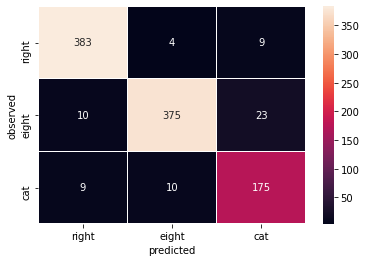

In [15]:
# Compute and plot Confusion matrix 

Ypred = model.predict_classes(Xtest)
cm = confusion_matrix(Y_test, Ypred, labels=[0,1,2])#, labels = words_selected)

ax = heatmap(cm, annot=True, fmt='d', 
                     linewidths=.2, 
                     xticklabels=words_selected, 
                     yticklabels=words_selected)

ax.set(xlabel='predicted',ylabel='observed')

Looks like we are doing well with this model. Next we are going to save this model to the model catalog and later deploy it as an HTTP endpoint. 

# Save the model to the Model Catalog

## Step 1: Publish your conda environment 

If you have: 
* modified a data science conda environment by adding a new library for example 
* created your own conda environment 

then you need to publish your conda environment. In the file `runtime.yaml` of the model artifact, we keep a reference of the conda environment that was used to train the model. That same conda environment can also be used as the inference environment used by the model deployment resource, if you decide to deploy the model later on. 

You can publish a conda by running the following `odsc conda` commands in the terminal or by executing the following cells. Initialize `odsc conda` first by providing a target bucket destination for your conda: 

In [16]:
# replace with your values: 
#!odsc conda init -b <YOUR_BUCKET_NAME> -n <YOUR_BUCKET_NAMESPACE>

In [17]:
# specify the slugname of the installed conda environment that you want to publish: 
#!odsc conda publish -s <YOUR_INSTALLED_CONDA_SLUG>

## Step 2: Prepare the model artifact

First we want to prepare a model artifact. That artifact is a zip archive of the following: 
* **score.py**:  an inference file is used to load the model object to memory and call the inference endpoint of the model (i.e. predict())
* **runtime.yaml**: a file describing the provenance of the model as well as providing a description of the runtime Conda environment of the model. This environment will be used in the upcoming OCI Data Science Model Deployment feature. 
* **your serialized model object**. This depends on the library you are using and the format you want to use. Models can be serialized as pickle (pkl) objects, ONNX, hdf5, json, pmml, etc. 

In the cell below, we are using the `prepare_generic_model()` function to generate a template model artifact. This function can handle any model trained with any ML library. You just have to fill in the blanks. The following files will be created under the `artifact_dir` directory: 

* `score.py`
* `runtime.yaml`

Since those are templates, next step will be to modify each file to ensure that our model can be saved to the catalog.  

In the `prepare_generic_model()` call below, we set the value of `inference_conda_env` to be the published conda environment path on object storage.  The `inference_conda_env` parameters keep track of which conda to use for model deployment. This is the same environment we used for training. You can find the path on object storage directly in the Environment Explorer in the card of your published environment just like the following screenshot shows: 

In [18]:
model_path = "./model-artifact"

In [19]:
artifact = prepare_generic_model(model_path,
                                 function_artifacts=False, 
                                 force_overwrite=True,
                                 inference_conda_env='oci://conda-env-ds@bigdatadatasciencelarge/conda_environments/cpu/speech-commands-with-deploy/1.0/speech-commands-with-deployv1_0')

Let's save our Keras model first: 

In [20]:
model.save(os.path.join(model_path, "cnn-speech.hdf5"))

And the mapping between classes and words: 

In [21]:
# Save that lookup dictionary to disk: 
pkl.dump(class_to_int, open(os.path.join(model_path,'class_label_lookup.pkl'),'wb'))

Let's modify score.py to account for the data transformation waveform -> mfcc with librosa: 

In [22]:
%%writefile {model_path}/score.py 

import json
import os
import keras 
import numpy as np
from keras.models import load_model as klm 
import librosa
import pickle as pkl

model_name = 'cnn-speech.hdf5'

# load the lookup dictionary:
words_selected = pkl.load(open('class_label_lookup.pkl','rb'))
# do a reverse lookup:
words_selected = { value: key for key, value in words_selected.items() }

def load_model(model_file_name=model_name):
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file_name in contents:
        modelpath = os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name)
        tmp = klm(modelpath)
        tmp._make_predict_function()
        return tmp 
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))


def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction':output from model.predict method}

    """
    
    from pandas import read_json, DataFrame
    from io import StringIO
    #X = read_json(StringIO(data))
    _ = json.loads(data)
    waveform = _['input']
    waveform = np.asarray(waveform)
    max_size = 32
    mfcc = librosa.feature.mfcc(waveform, sr=16000, n_mfcc=20)
    mfcc = np.pad(mfcc, pad_width=((0, 0),(0, max_size-mfcc.shape[1])), mode='constant')
    mfcc = mfcc.reshape(1,20,32,1)
    class_value = model.predict_classes(mfcc)
    return {'what-you-said-was': words_selected[class_value[0]]}

Overwriting ./model-artifact/score.py


## Testing the Artifact with Sample Payloads 

Here I use a sample waveform to test the artifact predict function: 

In [23]:
# directory where some sample wave files are located: 
sample_data_dir = '../data/'

# filenames 
files = ['6b81fead_nohash_0.wav',
         'ff2b842e_nohash_2.wav',
         'ccb1266b_nohash_1.wav']

In [24]:
waveform0, _ = librosa.load(sample_data_dir+files[0], mono=True, sr=None)
waveform1, _ = librosa.load(sample_data_dir+files[1], mono=True, sr=None)
waveform2, _ = librosa.load(sample_data_dir+files[2], mono=True, sr=None)

In [25]:
payload = {"input": waveform0.tolist()}

In [26]:
import sys
sys.path.insert(0, model_path)

from score import load_model, predict

_ = load_model()
predictions_test = predict(json.dumps(payload), _)
predictions_test

{'what-you-said-was': 'cat'}

In [27]:
from io import StringIO
tmp = json.dumps(payload)


In [28]:
_ = json.loads(tmp)

In [29]:
#from json import load, dumps
#
#with open("payload.json", 'r') as f: 
#    payload = load(f)

# Saving the Model to the Catalog 

We are now ready to save the artifact to the catalog: 

In [30]:
# using resource principal to authenticate to the model catalog: 
ads.set_auth(auth='resource_principal')

compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

In [31]:
mc_model = artifact.save(project_id=project_id, 
                         compartment_id=compartment_id, 
                         display_name="cnn-speech-commands",
                         description=f"Simple CNN model to classify speech commands",
                         ignore_pending_changes=True)
mc_model

INFO:ADS:{
  "git_branch": "None",
  "git_commit": "None",
  "repository_url": "None",
  "script_dir": "/home/datascience/demos/speech-commmands/notebooks/model-artifact",
  "training_script": "None"
}


,
id,ocid1.datasciencemodel.oc1.iad.amaaaaaanif7xwiaxkkrtqyn6vqgzgu67fqmvtyze6j4xypoudbketktvhiq
compartment_id,ocid1.compartment.oc1..aaaaaaaalcio324mqxi6egudwmc2wzix3yclcysmmji4cggvnj4b5timvw2q
project_id,ocid1.datascienceproject.oc1.iad.amaaaaaanif7xwiaot7v42xns7rha7cfvno76gzn4n2yhknw5c4i3jo5wpfq
display_name,cnn-speech-commands
description,Simple CNN model to classify speech commands
lifecycle_state,ACTIVE
time_created,2021-03-23 21:46:37.593000+00:00
created_by,ocid1.datasciencenotebooksession.oc1.iad.amaaaaaanif7xwiaa3o52rhzybjx3djdga75hl2ehkpgpvxduq65bfarfo2a
freeform_tags,{}
defined_tags,"{'Oracle-Tags': {'CreatedBy': 'ocid1.datasciencenotebooksession.oc1.iad.amaaaaaanif7xwiaa3o52rhzybjx3djdga75hl2ehkpgpvxduq65bfarfo2a', 'CreatedOn': '2021-03-23T21:46:37.128Z'}}"


# Create a Model Deployment

Here you have a couple of options. You can either create a model deployment directly in the console or do it programmatically via the OCI Python SDK. 

The cells below walk you through the programmatic deployment. If you decide to create the deployment in the console, you can skip this section and go to the "Invoking the Deployed Model `/predict` Endpoint" section  

In [32]:
import oci 
from oci.data_science import DataScienceClient, DataScienceClientCompositeOperations

from oci.data_science.models import ModelConfigurationDetails, InstanceConfiguration, \
                                    FixedSizeScalingPolicy, CategoryLogDetails, LogDetails, \
                                    SingleModelDeploymentConfigurationDetails, CreateModelDeploymentDetails

In [33]:
# using resource principals
auth = oci.auth.signers.get_resource_principals_signer()
data_science = DataScienceClient({}, signer=auth)

# OR the config + pem authn flow: 
#oci_config = oci.config.from_file('~/.oci/config', "DEFAULT")
#data_science = DataScienceClient(oci_config)

In [34]:
# Configuration of the model: 
# We deploy the sklearn model we saved to the model catalog in this notebook (catalog_entry.id)
# You can change the shape, instance_count, or the bandwidth of the load balancer (in Mbps)
model_configuration_details_object = ModelConfigurationDetails(model_id=mc_model.id,
                                                               instance_configuration=InstanceConfiguration(instance_shape_name='VM.Standard2.1'),
                                                               scaling_policy=FixedSizeScalingPolicy(instance_count=1),
                                                               bandwidth_mbps=10)

# Single Model Deployment Configuration
# Includes info about the deployment type and the model configuration details: 
# At the moment, only deployment+type='SINGLE_MODEL' is supported. 
single_model_config = SingleModelDeploymentConfigurationDetails(deployment_type='SINGLE_MODEL',
                                                                model_configuration_details=model_configuration_details_object)


# OPTIONAL - Configuration of the access and predict logs. 
# Make sure you have the proper policy in place to allow model deployment to emit predict/access logs. For example: 
# allow any-user to use log-content in tenancy where ALL {request.principal.type = 'datasciencemodeldeployment'}
logging_config = False
if logging_config: 

    access_log_group_id = "<your-log-group-id>"
    access_log_id = "<your-log-id>"
    predict_log_group_id = "<your-log-group-id>"
    predict_log_id = "<your-log-id>"

    logs_configuration_details_object = CategoryLogDetails(access=LogDetails(log_group_id=access_log_group_id,
                                                                             log_id=access_log_id),
                                                           predict=LogDetails(log_group_id=predict_log_group_id,
                                                                             log_id=predict_log_id))
else: 
    logs_configuration_details_object = {}


# Wrapping all of these configs into a model deploy configuration: 
# Replace with your own values for display_name, description, project, and compartment OCIDs 
model_deploy_configuration = CreateModelDeploymentDetails(display_name='speech-commands',
                                                          description='speech commands classification model',
                                                          project_id=os.environ['PROJECT_OCID'],
                                                          compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
                                                          model_deployment_configuration_details=single_model_config,
                                                          category_log_details=logs_configuration_details_object)

In [35]:
# Creating a model deployment. This action takes a few minutes

data_science_composite = DataScienceClientCompositeOperations(data_science)
model_deployment = data_science_composite.create_model_deployment_and_wait_for_state(model_deploy_configuration, 
                                                                                     wait_for_states=["SUCCEEDED", "FAILED"])

# Invoking the Deployed Model `/predict` Endpoint 

Last step is to invoke/call the model endpoint. Here again you can pick between resource principals or the config+key authn flow. 

In [36]:
import requests
import oci
from oci.signer import Signer

In [40]:
# model deployment endpoint. Here we assume that the notebook region is the same as the region where the model deployment occurs.
# Alternatively you can also go in the details page of your model deployment in the OCI console. Under "Invoke Your Model", you will find the HTTP endpoint 
# of your model. 
#uri = f"https://modeldeployment.{os.environ['NB_REGION']}.oci.customer-oci.com/{model_deployment.data.resources[0].identifier}/predict"
uri = f"https://modeldeployment.us-ashburn-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.iad.amaaaaaanif7xwiapgjmhlfauewhafdlban6qlfni76jjhuju2ofqwehi6wq/predict"
print(uri)

https://modeldeployment.us-ashburn-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.iad.amaaaaaanif7xwiapgjmhlfauewhafdlban6qlfni76jjhuju2ofqwehi6wq/predict


In [41]:
# Using Resource principal to authenticate against the model endpoint. Set using_rps=False if you are using 
# the config+key flow. 
using_rps = True
endpoint = uri

# payload: 
payload = {"input": waveform0.tolist()}
input_data = json.dumps(payload)

if using_rps: # using resource principal:     
    auth = oci.auth.signers.get_resource_principals_signer()
else: # using config + key: 
    config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
    auth = Signer(
        tenancy=config['tenancy'],
        user=config['user'],
        fingerprint=config['fingerprint'],
        private_key_file_location=config['key_file'],
        pass_phrase=config['pass_phrase'])

In [42]:
%%time
    
# submit request to model endpoint: 
requests.post(endpoint, json=input_data, auth=auth).json()

CPU times: user 36 ms, sys: 4.16 ms, total: 40.1 ms
Wall time: 1.02 s


{'what-you-said-was': 'cat'}

# What Next?

You can experiment and expand on the model trained in this notebook. Here are a few areas to explore: 

* increase the number of classes. Try to classify 10+ words 
* add noise to your examples. Create a more robust classifier. 
* try different CNN architectures 
* include an "other" class
* include a "silence" class

# References 

* Warden, P. 2018, "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition", [arXiv:1804.03209](https://arxiv.org/abs/1804.03209)
* Sainath, T.N., Parada, C. 2015 ["Convolutional Neural Networks for Small-footprint Keyword Spotting"]( https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43969.pdf)

# Appendix

Here's the network architecture for reference. 

![network-architecture](https://user-images.githubusercontent.com/5395649/46776515-cb378280-ccc0-11e8-8dcb-84db4156e981.png)

Below is a function I took directly from the `README` file that came with the dataset. This is a very useful function that ensures testing/validation data does not make its way in the training dataset. We will be using it to assign the sample (training, validation, testing) to which each audio clip belongs. 

In [ ]:
# From Warden (2018) : https://arxiv.org/abs/1804.03209

def which_set(filename, validation_percentage, testing_percentage):
    """Determines which data partition the file should belong to.
    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted 
    for example. To keep this stability, a hash of the filename is taken and used 
    to determine which set it should belong to. This determination only depends on 
    the name and the set proportions, so it won't change as other files are added.
    
    It's also useful to associate particular files as related (for example words 
    spoken by the same person), so anything after '_nohash_' in a filename is 
    ignored for set determination. This ensures that 'bobby_nohash_0.wav' and 
    'bobby_nohash_1.wav' are always in the same set, for example.
    
    Args
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.
    
    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    base_name = os.path.basename(filename)
    #print(base_name)
    # We want to ignore anything after '_nohash_' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_nohash_.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it. 
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest() 
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS)) 
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

Below is the data transformation that we apply to each audio clip before feeding the clip to the CNN model. Take a look at the [intro notebook](1-intro-to-audio-data.ipynb) where we discuss spectrogram and MFCCs. 

In [ ]:
def data_processing(filepath, max_len=32):
    """ Compute MFCCs for a given clip
    
    Args: 
        - filepath (str) : path of the wav file to analyze. 
        - max_len (int) : 
        
    Returns: 
        - Mel-frequency cepstral coefficients array. 
    """
    
    # Here we are loading the audio clip using librosa.
    waveform, sampling_rate = librosa.load(filepath, mono=True, sr=None)
    # compute the Mel-frequency cepstral coefficients. n_mfcc 
    # represents the number of coefficients to return. 
    mfcc = librosa.feature.mfcc(waveform, sr=16000, n_mfcc=20)
    
    # Not all clips have the same duration. Padding along the time dimension to 
    # ensure each clip has the same dimensions. Each image fed to the CNN needs 
    # to have the same dimensions. 
    mfcc = np.pad(mfcc, pad_width=((0, 0),(0, max_len-mfcc.shape[1])), mode='constant')
    return mfcc 